# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function

**Name**: *Michele Meo*

**Matricola**: *1599032*

Send the completed notebook before 26/11/2020 back to **simone.scardapane@uniroma1.it** with the object "[NNDS] Homework_1_\<id\>".

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [2]:
class PELU(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units

    def build(self, input_shape):
        
        self.alpha = self.add_weight( shape = (self.units,), 
                                    initializer = tf.keras.initializers.RandomUniform(0.1, 1.),
                                    constraint = tf.keras.constraints.NonNeg(),  # avoid negative values during training phase
                                    trainable = True)
        
        self.beta = self.add_weight( shape = (self.units,), 
                                    initializer = tf.keras.initializers.RandomUniform(0.1, 1.),
                                    constraint = tf.keras.constraints.NonNeg(),
                                    trainable = True)

    def call(self, inputs):
        # In order to avoid overflow errors I had to add a 0.1 constant term to each denominator 
        # in which the beta parameter appears, I even tried with smaller values like 1e-6 but it 
        # didn't work
        
        self.a = tf.cast((inputs >= 0), dtype=tf.float32) * ((self.alpha/(self.beta+0.1))*inputs) + \
                    tf.cast((inputs < 0), dtype=tf.float32) * (self.alpha*(tf.exp(inputs/(self.beta+0.1))-1))

        return self.a

**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [3]:
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.

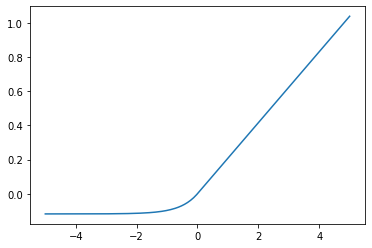

In [4]:
import matplotlib.pyplot as plt
x_range = tf.linspace(-5., 5., 200) # An equispaced grid of 200 points in [-5, +5]
y_range = pelu(x_range)

plt.plot(x_range.numpy(), y_range.numpy())  # check the pelu shape

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

In [5]:
# Ex. 2.2: Verifying the gradient w.r.t. alpha obtained from automatic differentiation

# Note: the 0.1 const. term addition in the pelu expression must be considered 
#       also in the evaluation of derivatives not implemented with the automatic differentiation

with tf.GradientTape() as t:
    y_range = pelu(x_range)

y_automatic_grad_alpha = t.jacobian(y_range, pelu.alpha)

y_grad_alpha = tf.where(x_range >= 0, 
                          x = x_range/(pelu.beta+0.1), 
                          y = tf.exp(x_range/(pelu.beta+0.1))-1)
y_grad_alpha = tf.reshape(y_grad_alpha, (-1, 1))

tf.reduce_all(tf.abs(y_grad_alpha - y_automatic_grad_alpha) < 1e-4)  # check automatic gradient with the known expression

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [6]:
# Ex. 2.3: Verifying the gradient w.r.t. beta obtained from automatic differentiation

with tf.GradientTape() as t:
    y_range = pelu(x_range)

y_automatic_grad_beta = t.jacobian(y_range, pelu.beta)

y_grad_beta = tf.where(x_range >= 0,
                        x = -(pelu.alpha*x_range)/(0.1 + pelu.beta)**2,
                        y = -(pelu.alpha*x_range*tf.exp(x_range/(0.1 + pelu.beta)))/(0.1 + pelu.beta)**2)
y_grad_beta = tf.reshape(y_grad_beta, (-1, 1))

tf.reduce_all(tf.abs(y_grad_beta - y_automatic_grad_beta) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

In [7]:
model = tf.keras.Sequential(layers=[
      tf.keras.layers.Dense(50),
      PELU(50),
      tf.keras.layers.Dense(11, activation='softmax')
])

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

In [8]:
# I decided to use the dataset from second laboratory lecture to implement the training loop

import pandas as pd

sensorless = pd.read_csv('/home/michele/Projects/DataScience/NN/Lab3/Sensorless_drive_diagnosis.txt',
                         header=None, sep=' ')

X = sensorless.values[:, 0:-1].astype('float32')
y = sensorless.values[:, -1:].astype('int64') - 1

In [9]:
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler  #  I normalize each data feature in the [0,1] range

X_tr, X_tst, y_tr, y_tst = model_selection.train_test_split(X, y, stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_tr)

X_tr = scaler.transform(X_tr)
X_tst = scaler.transform(X_tst)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_tst, y_tst)).batch(32)

In [11]:
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # best performance obtained with Adam optimizer
acc = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=adam, loss=cross_entropy, metrics=[acc])

In [12]:
history = model.fit(train_dataset, epochs=15, validation_data=test_dataset)  

Epoch 1/15
1372/1372 [==============================] - 4s 3ms/step - loss: 1.0972 - sparse_categorical_accuracy: 0.6368 - val_loss: 0.5818 - val_sparse_categorical_accuracy: 0.8078
Epoch 2/15
1372/1372 [==============================] - 3s 2ms/step - loss: 0.5224 - sparse_categorical_accuracy: 0.8173 - val_loss: 0.4535 - val_sparse_categorical_accuracy: 0.8372
Epoch 3/15
1372/1372 [==============================] - 3s 2ms/step - loss: 0.4370 - sparse_categorical_accuracy: 0.8372 - val_loss: 0.4022 - val_sparse_categorical_accuracy: 0.8428
Epoch 4/15
1372/1372 [==============================] - 3s 2ms/step - loss: 0.3894 - sparse_categorical_accuracy: 0.8490 - val_loss: 0.3664 - val_sparse_categorical_accuracy: 0.8532
Epoch 5/15
1372/1372 [==============================] - 5s 3ms/step - loss: 0.3567 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.3362 - val_sparse_categorical_accuracy: 0.8648
Epoch 6/15
1372/1372 [==============================] - 4s 3ms/step - loss: 0.3346 - spars

In [13]:
model = tf.keras.Sequential(layers=[
                           tf.keras.layers.Dense(50, activation='relu'),
                           tf.keras.layers.Dense(11, activation='softmax')])

model.compile(optimizer=adam, loss=cross_entropy, metrics=[acc])

In [14]:
history_relu = model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Epoch 1/15
1372/1372 [==============================] - 2s 1ms/step - loss: 1.4010 - sparse_categorical_accuracy: 0.6436 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.7244
Epoch 2/15
1372/1372 [==============================] - 2s 1ms/step - loss: 0.8777 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.7513 - val_sparse_categorical_accuracy: 0.8063
Epoch 3/15
1372/1372 [==============================] - 2s 1ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.8027 - val_loss: 0.6202 - val_sparse_categorical_accuracy: 0.8207
Epoch 4/15
1372/1372 [==============================] - 2s 1ms/step - loss: 0.5905 - sparse_categorical_accuracy: 0.8191 - val_loss: 0.5469 - val_sparse_categorical_accuracy: 0.8314
Epoch 5/15
1372/1372 [==============================] - 2s 1ms/step - loss: 0.5329 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.5014 - val_sparse_categorical_accuracy: 0.8377
Epoch 6/15
1372/1372 [==============================] - 2s 1ms/step - loss: 0.4948 - spars

I show two plots in which the accuracy value for each epoch is represented: in the first plot a comparison between the accuracy obtained on the train set and on the validation set, in the second plot a comparison between the accuracy obtained on validation set with PELU and ReLU.

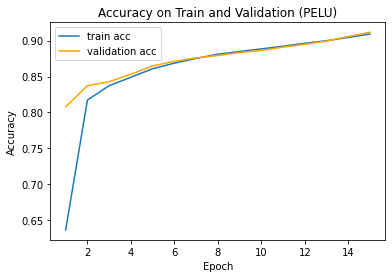

In [15]:
plt.plot(range(1, 16), history.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(range(1, 16), history.history['val_sparse_categorical_accuracy'], label='validation acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy on Train and Validation (PELU)')
plt.legend()
plt.show()

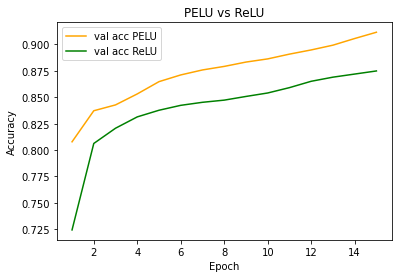

In [16]:
plt.plot(range(1, 16), history.history['val_sparse_categorical_accuracy'], label='val acc PELU', color='orange')
plt.plot(range(1, 16), history_relu.history['val_sparse_categorical_accuracy'], label='val acc ReLU', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('PELU vs ReLU')
plt.legend()
plt.show()

### Optional: understanding saving/loading of models

TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [ ]:
model.save('pelu_model')
del PELU # This is needed to remove any reference to PELU from memory
reloaded_model = tf.keras.models.load_model('pelu_model')

In [ ]:
print("Original model:", model)
print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.